In [1]:
from main_functions import *
from plots import *
import time

In [2]:
# Global variables

K = 8000  # Number of samples
burnin = 2000
y = 1

# Prior values from TrueSkill
mu_s1 = 25  # Prior mean of s1
mu_s2 = 25  # Prior mean of s2
sig1 = 25 / 3  # Prior standard deviation of s1
sig2 = 25 / 3  # Prior standard deviation of s2
beta = 25 / 6  # Prior standard deviation of t (outcome)

M = np.array([1, -1], dtype=float).T  # Transformation Matrix

consider_draw = False  # Whether draws should be considered or not

### Gibbs Sampling


In [3]:
# Draw samples when y = 1
start_time = time.time()
samples_s1, samples_s2 = gibbs_sampler(
    mu_s1, mu_s2, sig1, sig2, beta, M, y, K, consider_draw=False
)
elapsed_time = time.time() - start_time

In [4]:
mean_s1_after_burnin = np.mean(samples_s1[burnin:])
mean_s2_after_burnin = np.mean(samples_s2[burnin:])
var_s1_after_burnin = np.var(samples_s1[burnin:])
var_s2_after_burnin = np.var(samples_s2[burnin:])

print(f"Time taken: {elapsed_time}")
print(f"Mean of s1 after burn-in: {mean_s1_after_burnin:.2f}")
print(f"Mean of s2 after burn-in: {mean_s2_after_burnin:.2f}")
print(f"Var of s1 after burn-in: {var_s1_after_burnin:.2f}")
print(f"Var of s2 after burn-in: {var_s2_after_burnin:.2f}")

Time taken: 3.9955289363861084
Mean of s1 after burn-in: 29.38
Mean of s2 after burn-in: 20.71
Var of s1 after burn-in: 50.05
Var of s2 after burn-in: 50.35


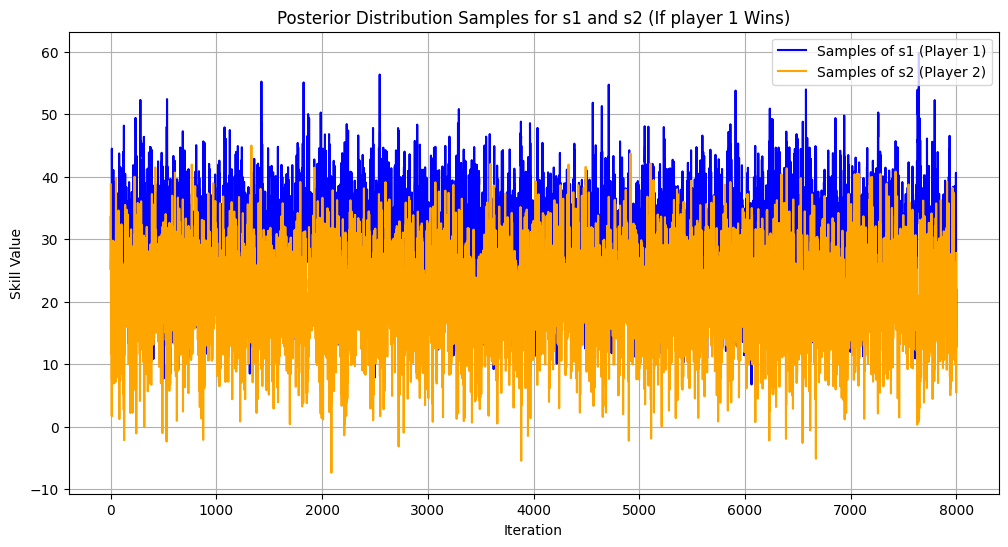

In [5]:
# Q4.a - Plot the samples of the posterior distributions generated by the Gibbs sampler when y = 1
plot_posterior_samples(samples_s1, samples_s2)

In [6]:
# Calculate the running mean for s1 and s2 to observe convergence over iterations
s1_running_mean = np.cumsum(samples_s1) / np.arange(1, K + 1)
s1_uncertainty = [np.std(samples_s1[: i + 1]) for i in range(K)]
s2_running_mean = np.cumsum(samples_s2) / np.arange(1, K + 1)
s2_uncertainty = [np.std(samples_s2[: i + 1]) for i in range(K)]

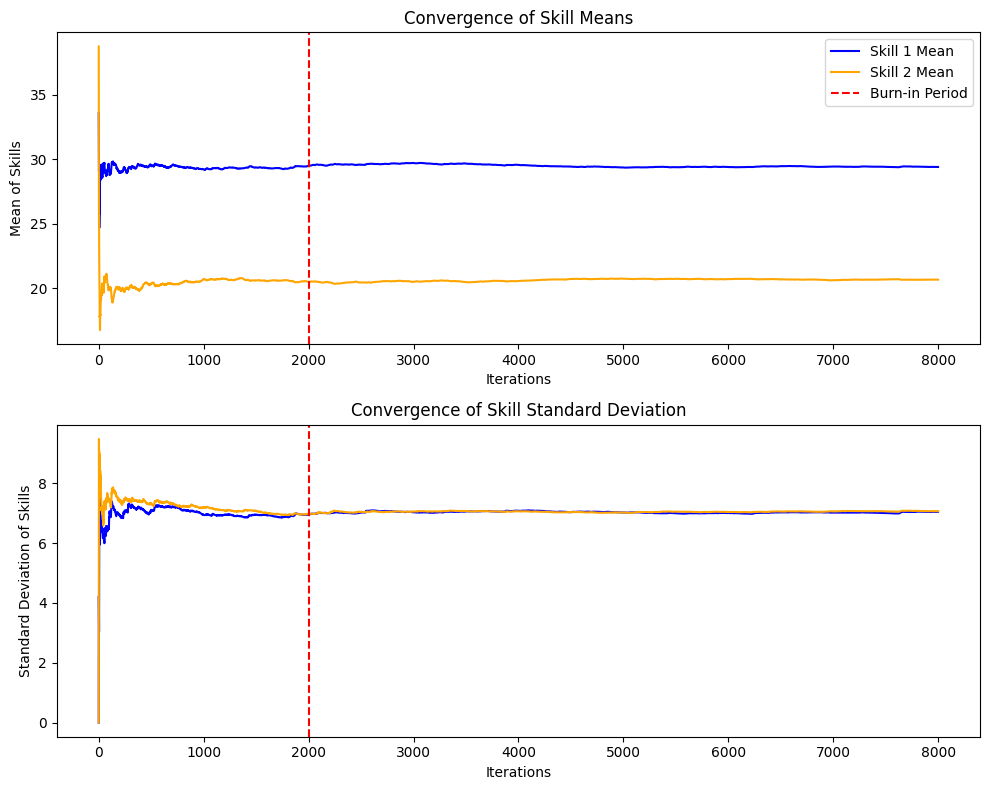

In [7]:
# Plot the convergence of the running mean and std of the samples to evaluate the value of burn-in
plot_convergence(
    s1_running_mean, s2_running_mean, s1_uncertainty, s2_uncertainty, burnin
)

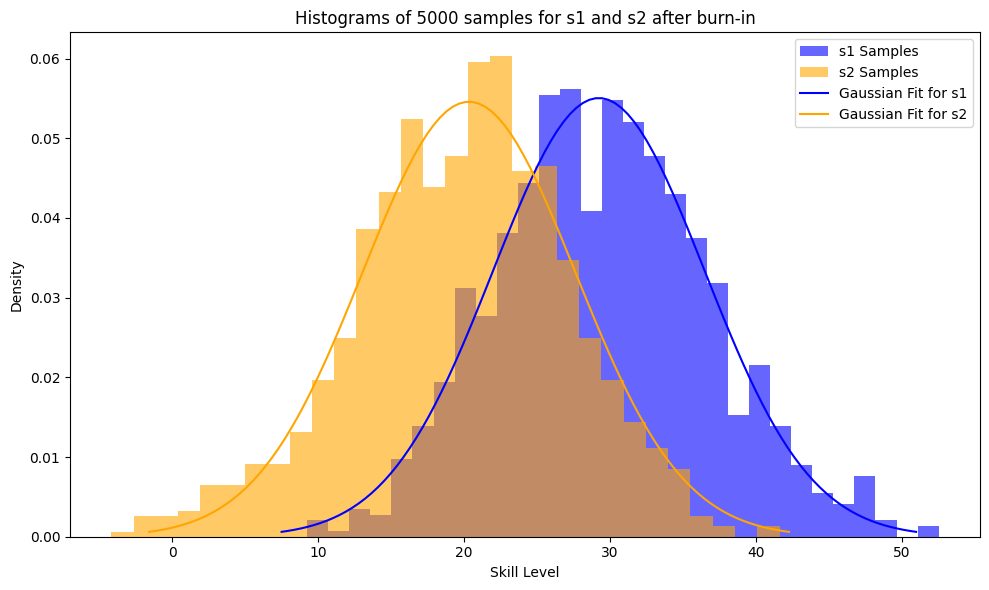

Time taken for 5000 samples: 2.8448750972747803


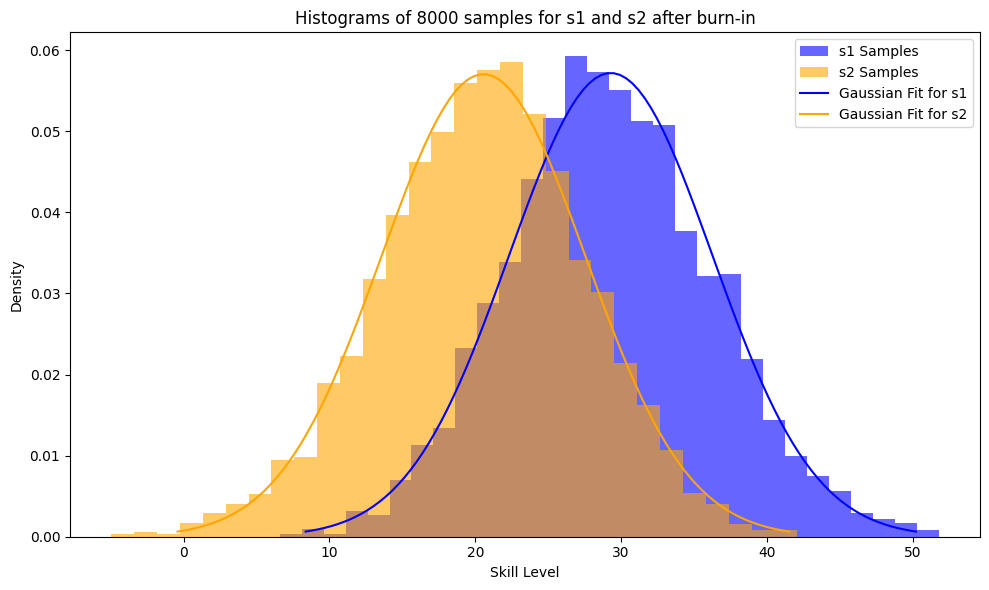

Time taken for 8000 samples: 4.116396903991699


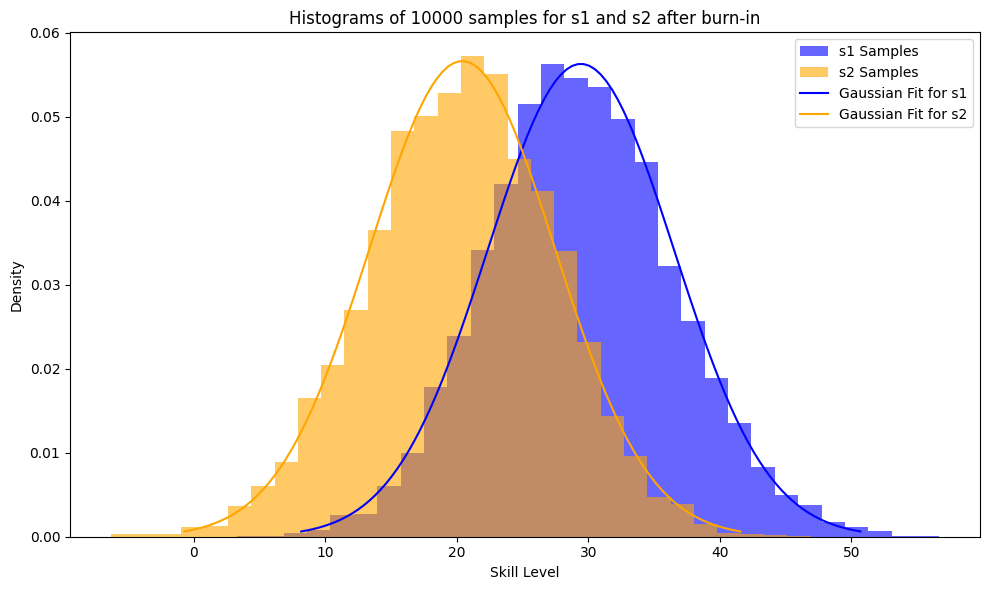

Time taken for 10000 samples: 5.941102981567383


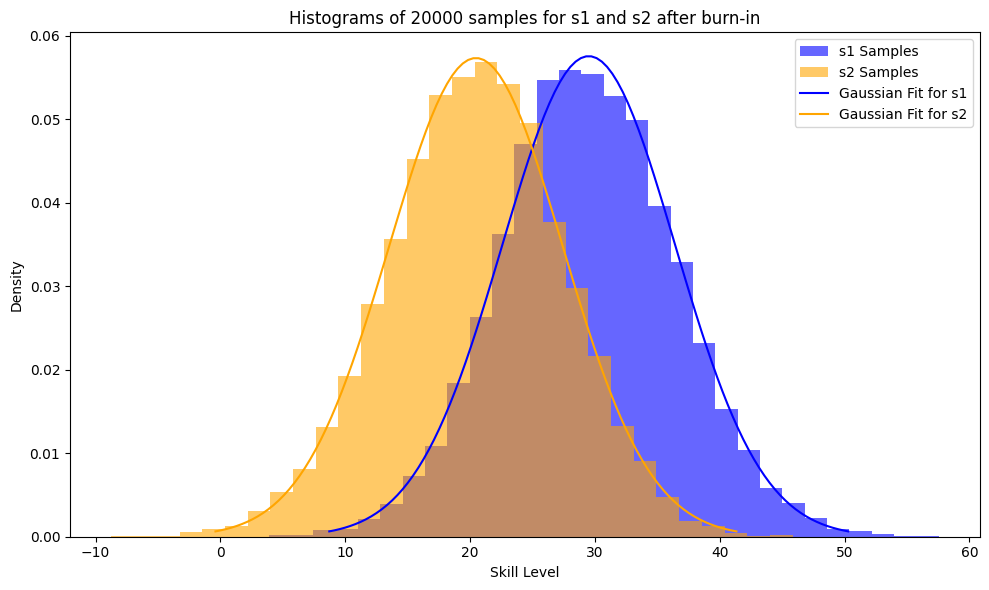

Time taken for 20000 samples: 10.874789953231812


(array([13.36713557, 22.20612206, 23.89235928, ..., 24.1351812 ,
        43.07792206, 31.12539398]),
 array([28.71667143, 19.73760022, 21.39866331, ..., 15.23751839,
        33.37277714, 22.29461228]))

In [8]:
# Run gibbs sampling with various number of iterations
compare_gibbs_iterations(mu_s1, mu_s2, sig1, sig2, beta, M, y, burnin)

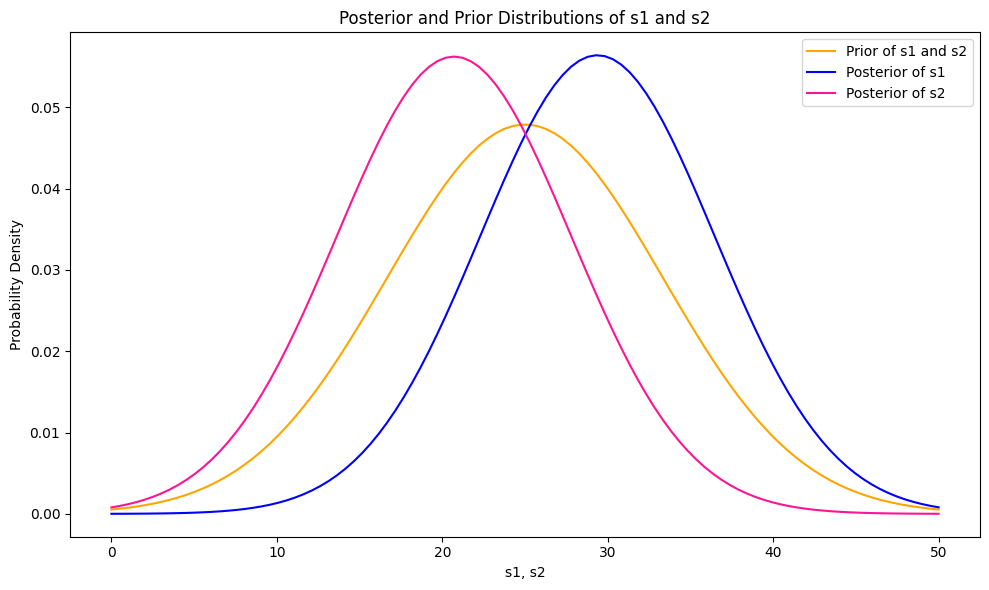

In [9]:
# Q4.d - plot prior and posterior distributions of s1 and s2
plot_prior_and_posterior(mu_s1, sig1, samples_s1, samples_s2, burnin)

### Assumed Density Filtering (ADF)


In [10]:
# read dataset and drop unnecessary columns
df = pd.read_csv("SerieA.csv")
df = df.drop(columns=["yyyy-mm-dd", "HH:MM"])
df.head(5)

,team1,team2,score1,score2
0,Chievo,Juventus,2,3
1,Lazio,Napoli,1,2
2,Torino,Roma,0,1
3,Sassuolo,Inter,1,0
4,Parma,Udinese,2,2


In [11]:
# Q5.a - Estimate the skill of all the teams in the dataset (without considering draws)
original_team_stats = ADF(
    df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, False, False
)

Row 100 is finished.
-------------------------
Row 200 is finished.
-------------------------
Row 300 is finished.
-------------------------


In [12]:
# sort teams by their mean of skills
original_sorted_teams = dict(
    sorted(original_team_stats.items(), key=lambda item: item[1]["mu"], reverse=True)
)
print(original_sorted_teams)

{'Napoli': {'mu': np.float64(29.040564593038443), 'sig': np.float64(1.540616674987867)}, 'Juventus': {'mu': np.float64(28.37700512775884), 'sig': np.float64(1.8539957096468336)}, 'Milan': {'mu': np.float64(28.319280606808903), 'sig': np.float64(1.5358379240350506)}, 'Atalanta': {'mu': np.float64(27.843610853579424), 'sig': np.float64(1.2161892529408234)}, 'Inter': {'mu': np.float64(27.700320143089034), 'sig': np.float64(1.301655019045283)}, 'Torino': {'mu': np.float64(27.592891011996674), 'sig': np.float64(1.4957707644442444)}, 'Roma': {'mu': np.float64(27.059343306047968), 'sig': np.float64(1.4222984611701457)}, 'Lazio': {'mu': np.float64(25.7356795679848), 'sig': np.float64(1.291068683953443)}, 'Sampdoria': {'mu': np.float64(24.578158847440612), 'sig': np.float64(1.2140328490906636)}, 'Bologna': {'mu': np.float64(24.29346651014897), 'sig': np.float64(1.3251097817213537)}, 'Spal': {'mu': np.float64(24.173503804940758), 'sig': np.float64(1.3316461647788669)}, 'Udinese': {'mu': np.float

In [13]:
# save rankings in a .txt file
save_rankings(original_sorted_teams, "original_rankings.txt")

In [14]:
# Q5.b - Estimate the skill of all the teams in the shuffled dataset (without considering draws)
shuffled_df = df.sample(frac=1).reset_index(drop=True)
shuffled_df.head(5)

,team1,team2,score1,score2
0,Parma,Napoli,0,4
1,Sampdoria,Parma,2,0
2,Spal,Milan,2,3
3,Cagliari,Fiorentina,2,1
4,Bologna,Milan,0,0


In [16]:
shuffled_team_stats = ADF(
    shuffled_df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, False, False
)

Row 300 is finished.
-------------------------


In [17]:
# sort teams by their mean of skills (shuffled dataset)
shuffled_sorted_teams = dict(
    sorted(shuffled_team_stats.items(), key=lambda item: item[1]["mu"], reverse=True)
)
print(shuffled_sorted_teams)

{'Juventus': {'mu': np.float64(30.908906438242397), 'sig': np.float64(1.429803889052688)}, 'Napoli': {'mu': np.float64(29.48730119907938), 'sig': np.float64(1.3622978575723317)}, 'Torino': {'mu': np.float64(29.004861689327882), 'sig': np.float64(1.4469877981749701)}, 'Roma': {'mu': np.float64(28.607753950917395), 'sig': np.float64(1.3540192917992695)}, 'Atalanta': {'mu': np.float64(28.40836080511108), 'sig': np.float64(1.2802010495659037)}, 'Milan': {'mu': np.float64(27.902139458277244), 'sig': np.float64(1.4392932704223058)}, 'Inter': {'mu': np.float64(27.647297785865515), 'sig': np.float64(1.1901541094405064)}, 'Lazio': {'mu': np.float64(26.519379014642414), 'sig': np.float64(1.2353372875728612)}, 'Sampdoria': {'mu': np.float64(25.801658140465772), 'sig': np.float64(1.2083305279268017)}, 'Sassuolo': {'mu': np.float64(24.72878301345529), 'sig': np.float64(1.6081126479261247)}, 'Udinese': {'mu': np.float64(24.715879522207896), 'sig': np.float64(1.323334849541305)}, 'Spal': {'mu': np.fl

In [18]:
# save rankings in a .txt file (shuffled dataset)
save_rankings(shuffled_sorted_teams, "shuffled_df_rankings.txt")

In [19]:
# Q6 - compute the predictions and compare with the actual results
team_stats, correct_guesses, total_guesses = ADF(
    df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, True, False
)

Row 100 is finished.
-------------------------
Row 200 is finished.
-------------------------
Row 300 is finished.
-------------------------


In [20]:
# prediction rate
calculate_prediction_rate(correct_guesses, total_guesses)

Correct Guesses: 180
Total Guesses: 272
Prediction Rate: 66.1765%


In [21]:
# random guessing
team_stats_rg, correct_guesses_rg, total_guesses_rg = ADF(
    df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, True, True
)
calculate_prediction_rate(correct_guesses_rg, total_guesses_rg)

Row 100 is finished.
-------------------------
Row 200 is finished.
-------------------------
Row 300 is finished.
-------------------------
Correct Guesses: 125
Total Guesses: 272
Prediction Rate: 45.9559%


### Moment Matching


In [22]:
# Q8 - Implement the message-passing algorithm to compute the posterior distribution for each of the two skills
new_m_s1, new_var_s1, new_m_s2, new_var_s2 = moment_matching(
    mu_s1, mu_s2, sig1, sig2, beta, y
)
print(
    f" Mean of s1 (MM): {new_m_s1}\n Variance of s1 (MM): {new_var_s1}\n Mean of s2 (MM): {new_m_s2}\n Variance of s2 (MM): {new_var_s2}"
)

 Mean of s1 (MM): 29.43269200446036
 Variance of s1 (MM): 49.795686038037616
 Mean of s2 (MM): 20.567307995539636
 Variance of s2 (MM): 49.795686038037616


In [23]:
# posterior distributions for s1 and s2 using the updated means and variances from moment matching
s1_dist = norm(loc=new_m_s1, scale=np.sqrt(new_var_s1))
s2_dist = norm(loc=new_m_s2, scale=np.sqrt(new_var_s2))

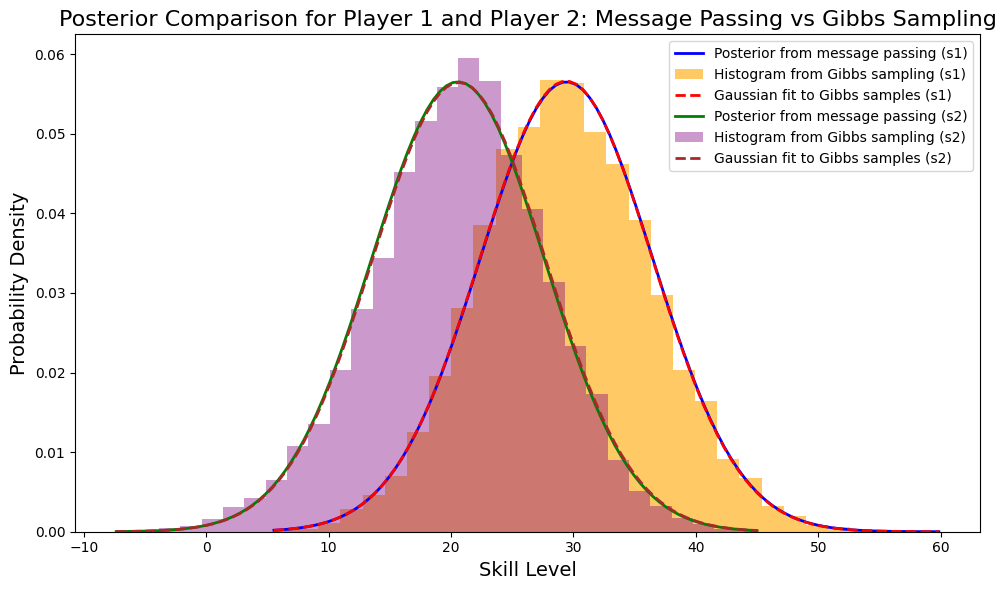

In [24]:
# plot posteriors from moment-matching and Gibbs sampling
plot_mm_gibbs(samples_s1, samples_s2, s1_dist, s2_dist)

### Rugby Dataset


In [25]:
# Q9 - Test the Trueskill methods on rugby dataset
rugby_df = pd.read_csv("rugby.csv")
rugby_df.head(5)

,date,home_team,away_team,home_score,away_score,competition,stadium,city,country,neutral,world_cup
0,1871-03-27,Scotland,England,1,0,1871 Scotland v England International,Raeburn Place,Edinburgh,Scotland,False,False
1,1872-02-05,England,Scotland,2,1,1871–72 Home Nations International,The Oval,London,England,False,False
2,1873-03-03,Scotland,England,0,0,1872–73 Home Nations International,West of Scotland F.C.,Glasgow,Scotland,False,False
3,1874-02-23,England,Scotland,1,0,1873–74 Home Nations International,The Oval,London,England,False,False
4,1875-02-15,England,Ireland,2,0,1874–75 Home Nations rugby union matches,The Oval,London,England,False,False


In [26]:
# preprocess the rugby dataset
rugby_df = preprocess(rugby_df)
rugby_df.head(5)

,team1,team2,score1,score2
2320,Wales,England,16,21
2321,Italy,Ireland,3,26
2322,France,Scotland,15,8
2323,Ireland,France,18,11
2324,England,Italy,47,17


In [27]:
# run ADF on rugby dataset
rugby_team_stats, rugby_correct_guesses, rugby_total_guesses = ADF(
    rugby_df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, True, False
)

Row 2400 is finished.
-------------------------
Row 2500 is finished.
-------------------------
Row 2700 is finished.
-------------------------


In [32]:
# sort the teams
rugby_sorted_teams = dict(
    sorted(rugby_team_stats.items(), key=lambda item: item[1]["mu"], reverse=True)
)
print(rugby_sorted_teams)

{'Ireland': {'mu': np.float64(30.045376709648103), 'sig': np.float64(0.7167099656451611)}, 'New Zealand': {'mu': np.float64(29.927534450482238), 'sig': np.float64(0.6944420498008854)}, 'South Africa': {'mu': np.float64(28.768429978160885), 'sig': np.float64(0.6498841585055433)}, 'England': {'mu': np.float64(28.3036204952784), 'sig': np.float64(0.6576265775137394)}, 'France': {'mu': np.float64(27.366999449772557), 'sig': np.float64(0.6437674801963004)}, 'Australia': {'mu': np.float64(26.402672065855192), 'sig': np.float64(0.6460589725206681)}, 'Wales': {'mu': np.float64(26.14766119710806), 'sig': np.float64(0.5825862915920753)}, 'Scotland': {'mu': np.float64(25.583601813823314), 'sig': np.float64(0.6989581557863066)}, 'Argentina': {'mu': np.float64(24.20713810772183), 'sig': np.float64(0.7177776208489755)}, 'Italy': {'mu': np.float64(20.487438516844094), 'sig': np.float64(1.2892739027584823)}}


In [34]:
# save rankings in a .txt file (rugby dataset)
save_rankings(rugby_sorted_teams, "rugby_df_rankings.txt")

In [28]:
# prediction rate for the rugby dataset
calculate_prediction_rate(rugby_correct_guesses, rugby_total_guesses)

Correct Guesses: 322
Total Guesses: 452
Prediction Rate: 71.2389%


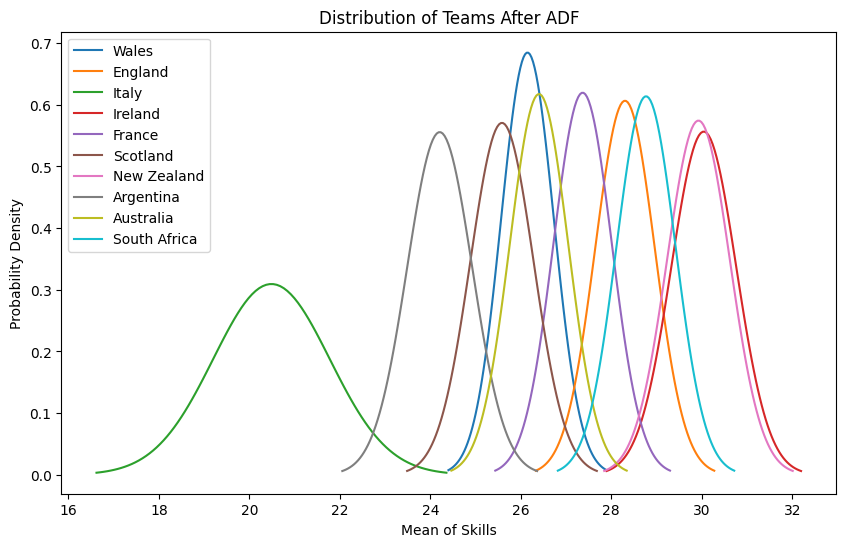

In [29]:
# plot the probability density functions of rugby teams' skill distributions
plot_team_distribution(rugby_team_stats)

### Considering Draws


In [30]:
# Q10 - running ADF when we consider draws
team_stats_with_draw, correct_guesses_with_draw, total_guesses_with_draw = (
    ADF_with_draw
) = ADF_with_draw(df, mu_s1, mu_s2, sig1, sig2, beta, K, burnin, M, True, False)

Row 0 is finished.
-------------------------
Row 100 is finished.
-------------------------
Row 200 is finished.
-------------------------
Row 300 is finished.
-------------------------


In [31]:
# calculating the prediction rate when considering draws
calculate_prediction_rate(correct_guesses_with_draw, total_guesses_with_draw)

Correct Guesses: 158
Total Guesses: 380
Prediction Rate: 41.5789%
